# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [511]:
import os
import xlrd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import math
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [518]:
columnas = ['Fecha', '00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00',
                           '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00',
                           '19:00', '20:00', '21:00', '22:00', '23:00']
path  = r'C:\Users\BocanegraMartinez\Documents\GitHub\evaluacion-lcarrietas\datos\precios'
files = os.listdir(path)
precios_df = pd.DataFrame(columns = columnas)
rango = [x for x in range(25)]

In [519]:
for x in files:
    precios = pd.read_excel(path+"\\"+x, usecols=rango,names = columnas)
    precios = precios.dropna(thresh=2)
    precios = precios.drop(precios.index[0])
    precios = precios.drop_duplicates(precios.columns[precios.columns.isin(['Fecha'])])
    precios_df = pd.concat([precios_df, precios])
    
precios_df.reset_index(drop=True, inplace=True)    

In [520]:
precios_df

,Fecha,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,1995-07-20,NaN,1.073000,1.073000,1.073000,1.073000,1.073000,1.073000,1.073000,1.074000,...,1.073000,1.073000,1.073000,1.073000,1.074000,1.897000,1.897000,1.897000,1.073000,1.073000
1,1995-07-21,1.073,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,6.000000,6.000000,...,5.000000,1.000000,1.000000,5.000000,12.000000,16.670000,11.929000,5.000000,1.000000,1.000000
2,1995-07-22,1.073,1.073000,1.000000,1.000000,1.000000,1.073000,1.303000,1.303000,1.303000,...,1.073000,1.000000,1.000000,1.000000,1.303000,2.500000,2.500000,1.303000,1.073000,1.073000
3,1995-07-23,1.073,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,...,1.000000,0.100000,0.100000,1.000000,1.238000,1.238000,1.238000,1.238000,1.073000,1.000000
4,1995-07-24,1,1.000000,0.990000,1.000000,1.000000,1.073000,3.000000,3.000000,3.000000,...,1.073000,1.073000,3.000000,2.000000,18.630000,22.500000,9.256000,3.000000,1.073000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,2018-05-01,64.2292,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,...,71.229226,71.229226,69.229226,81.229226,86.229226,86.229226,86.229226,81.229226,71.229226,64.229226
8322,2018-05-02,63.3328,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,...,83.832816,83.832816,80.832816,80.832816,83.832816,83.832816,83.832816,80.832816,80.832816,67.832816
8323,2018-05-03,63.7108,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,...,79.710848,79.710848,79.710848,67.710848,79.710848,79.710848,79.710848,67.710848,67.710848,63.710848
8324,2018-05-04,61.5435,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,...,65.543453,65.543453,65.543453,65.543453,65.543453,72.543453,65.543453,65.543453,65.543453,64.043453


In [521]:
precios_df['Promedio'] = precios_df.mean(axis=1,numeric_only=True)
#precios_df = precios_df[['Fecha', 'Promedio']]
precios_df = precios_df.loc[:,('Fecha','Promedio')]
precios_df

,Fecha,Promedio
0,1995-07-20,1.409435
1,1995-07-21,5.091783
2,1995-07-22,1.278043
3,1995-07-23,0.947870
4,1995-07-24,4.449652
...,...,...
8321,2018-05-01,71.990096
8322,2018-05-02,76.941468
8323,2018-05-03,71.471718
8324,2018-05-04,64.847801


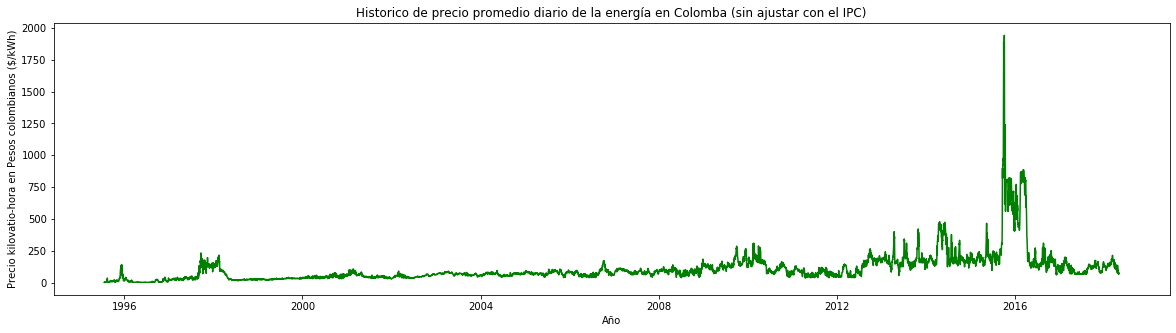

In [522]:
precios_df['Fecha']=pd.to_datetime(precios_df['Fecha'])

plt.figure(figsize=(20,5))
plt.title('Historico de precio promedio diario de la energía en Colomba (sin ajustar con el IPC)')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora en Pesos colombianos ($/kWh)')
plt.plot(precios_df['Fecha'], precios_df['Promedio'], color='green')

#Se muestra el grafico
plt.show()

> [Documento con la serie histórica del IPC en colombia:](https://totoro.banrep.gov.co/analytics/saw.dll?Download&Format=excel2007&Extension=.xls&BypassCache=true&lang=es&NQUser=publico&NQPassword=publico123&path=%2Fshared%2FSeries%20Estad%C3%ADsticas_T%2F1.%20IPC%20base%202018%2F1.2.%20Por%20a%C3%B1o%2F1.2.5.IPC_Serie_variaciones)

Se lee el documento y se extrae el IPC compañado de la fecha correspondiente y `después se une al DataFrame de la serie de precios`

In [523]:
serieIPC = pd.read_excel(r'C:\Users\BocanegraMartinez\Documents\GitHub\evaluacion-lcarrietas\datos\1.2.5.IPC_Serie_variaciones.xlsx',header=12, skipfooter=6, keep_default_na=False)
serieIPC.columns = ['FechaIPC', 'Indice', "no","no2", "no3" ]
serieIPC = serieIPC[['FechaIPC','Indice']]
serieIPC['FechaIPC'] =serieIPC['FechaIPC'].apply(lambda x: datetime.strptime(str(x),"%Y%m"))
serieIPC['FechaIPC'] = pd.to_datetime(serieIPC['FechaIPC']).dt.to_period('M')
precios_df['FechaIPC'] = pd.to_datetime(precios_df['Fecha']).dt.to_period('M')
serieIPC

,FechaIPC,Indice
0,2020-02,104.94
1,2020-01,104.24
2,2019-12,103.80
3,2019-11,103.54
4,2019-10,103.43
...,...,...
783,1954-11,0.03
784,1954-10,0.03
785,1954-09,0.03
786,1954-08,0.03


In [524]:
deflactados = pd.merge(precios_df, serieIPC, on="FechaIPC", how="left")
deflactados

,Fecha,Promedio,FechaIPC,Indice
0,1995-07-20,1.409435,1995-07,20.93
1,1995-07-21,5.091783,1995-07,20.93
2,1995-07-22,1.278043,1995-07,20.93
3,1995-07-23,0.947870,1995-07,20.93
4,1995-07-24,4.449652,1995-07,20.93
...,...,...,...,...
8321,2018-05-01,71.990096,2018-05,99.16
8322,2018-05-02,76.941468,2018-05,99.16
8323,2018-05-03,71.471718,2018-05,99.16
8324,2018-05-04,64.847801,2018-05,99.16


> Utilizando la fómula encontrada en el siguiente [enlace](https://yirepa.es/deflactar.html) se procede a `deflactar` la serie. Tomando como IPC base el correspondiente al primer dato de la Serie de Precios.

In [525]:
ipcIinicial=deflactados['Indice'][0]
deflactados['precioDeflactado'] = deflactados['Promedio']*(ipcIinicial/deflactados['Indice'])
deflactados

,Fecha,Promedio,FechaIPC,Indice,precioDeflactado
0,1995-07-20,1.409435,1995-07,20.93,1.409435
1,1995-07-21,5.091783,1995-07,20.93,5.091783
2,1995-07-22,1.278043,1995-07,20.93,1.278043
3,1995-07-23,0.947870,1995-07,20.93,0.947870
4,1995-07-24,4.449652,1995-07,20.93,4.449652
...,...,...,...,...,...
8321,2018-05-01,71.990096,2018-05,99.16,15.195166
8322,2018-05-02,76.941468,2018-05,99.16,16.240268
8323,2018-05-03,71.471718,2018-05,99.16,15.085751
8324,2018-05-04,64.847801,2018-05,99.16,13.687621


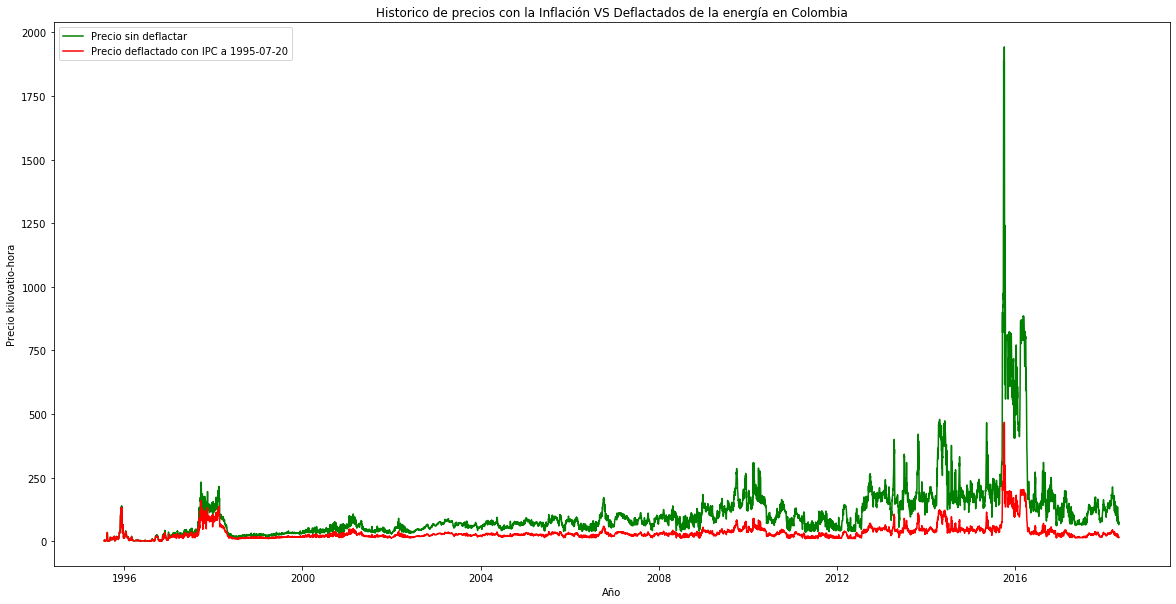

In [529]:
plt.figure(figsize=(20,10))
plt.title('Historico de precios con la Inflación VS Deflactados de la energía en Colombia')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora')
plt.plot(deflactados['Fecha'], deflactados['Promedio'],label="Precio sin deflactar", color='green')
plt.plot(deflactados['Fecha'], deflactados['precioDeflactado'],label="Precio deflactado con IPC a 1995-07-20", color='red')
plt.legend()
plt.show()

In [530]:
print("Deflactados: Mínimo: "+ str(min(deflactados['precioDeflactado'])) + " Máximo: " + str(max(deflactados['precioDeflactado'])))
print("Promedios: Minimo: " + str(min(deflactados['Promedio'])) + " Máximo: " + str(max(deflactados['Promedio'])))

Deflactados: Mínimo: 0.5215217391304349 Máximo: 467.4693546066912
Promedios: Minimo: 0.5215217391304349 Máximo: 1942.6891764782608


## Transformaciones

> Se realizan 4 transformaciones (Estandarizado, Logaritmo Natural, Raíz Cuadrada, Raíz Cúbica) a los precios deflactados para comparar si mejora la presición del modelo con respecto a los precios sin ninguna transformación.

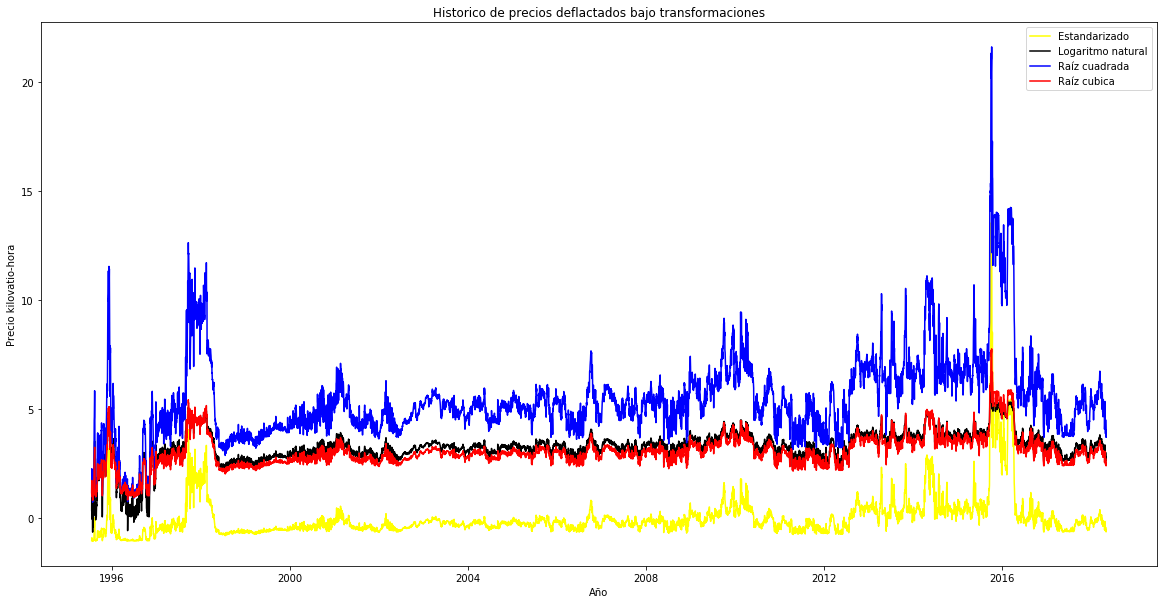

In [532]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = [[x] for x in deflactados['precioDeflactado']]
scaler.fit(data)

deflactados['Estandarizado'] = scaler.transform(data)
deflactados['LogNatural'] = np.log(deflactados['precioDeflactado'])
deflactados['RaizCuadrada'] = np.sqrt(deflactados['precioDeflactado'])
deflactados['RaizCubica'] = np.cbrt(deflactados['precioDeflactado'])

plt.figure(figsize=(20,10))
plt.title('Historico de precios deflactados bajo transformaciones')
plt.xlabel('Año')
plt.ylabel('Precio kilovatio-hora')
plt.plot(deflactados['Fecha'], deflactados['Estandarizado'],label="Estandarizado", color='yellow')
plt.plot(deflactados['Fecha'], deflactados['LogNatural'],label="Logaritmo natural", color='black')
plt.plot(deflactados['Fecha'], deflactados['RaizCuadrada'],label="Raíz cuadrada", color='blue')
plt.plot(deflactados['Fecha'], deflactados['RaizCubica'],label="Raíz cubica", color='red')
#plt.plot(deflactados['Fecha'], deflactados['precioDeflactado'],label="Precio deflactado", color='yellow')
plt.legend()
plt.show()

## Modelo ADALINE

In [533]:
# Este es un modelo especializado en series de tiempo
#
class AdalineTS:
    def __init__(self,
                 P=None,               # número de retardos a usar
                 learning_rate=0.001): # tasa de aprendizaje

        self.P = P
        self.learning_rate = learning_rate
        self.X = []
        self.coef_ = [0.] * P
        self.intercept_ = 0.

    def predict(self):
        if len(self.X) < self.P:
            return None
        X = np.array(self.X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

    def fit(self, d):
        y = self.predict()
        if y is not None:
            e = d - y
            self.coef_ += 2 * self.learning_rate * e * np.array(self.X)
            self.intercept_ += 2 * self.learning_rate * e
        self.X.append(d)
        if len(self.X) > self.P:
            self.X.pop(0)

In [534]:
# Se crean subconjuntos de datos, uno por cada transformación
dDef = deflactados.loc[:,('precioDeflactado')]
dNor = deflactados.loc[:,('Estandarizado')]
dLog = deflactados.loc[:,('LogNatural')]
dR2 = deflactados.loc[:,('RaizCuadrada')]
dR3 = deflactados.loc[:,('RaizCubica')]


<p>En la práctica, es imposible estimar a partir de una serie temporal y de N observaciones, la media, la varianza, la ACF y la PACF del proceso estacionario Y(t) del  que  supuestamente  procede  dicha  serie.  En  particular,  sólo  en  el  vector  de  medias  y  en  la  matriz  de  varianzas-covarianzas  de  la  muestra Y asociada con la serie y figuran 1 + N parámetros distintos. 
<p>No  obstante,  en  la  práctica  sí  pueden  estimarse  con  cierta  precisión  las  K  primeras  autocorrelaciones  simples  y  parciales  de  Y(t)  a  partir  de  una  serie  temporal  de  N observaciones, siempre que K sea un número bastante más reducido que N.
    
[Tomado de www.ucm.es](https://www.ucm.es/data/cont/docs/518-2013-11-11-JAM-IAST-Libro.pdf)

Basados en lo anterior se procede a realizar el analisis de correlación de los valores de la serie con una muestra de cada sunconjunto de datos extraídos anteriormente y se realiza el modelo de predicción.

## Serie de Precios Deflactada Sin Transformación

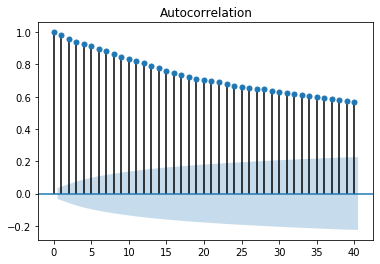

In [535]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(dDef[5000:],lags=40)
pyplot.show()

In [536]:
# Disminución lenta de la serie y por fuera de los intervalos de confianza
# Por lo tanto se procede a la
# diferenciación de la serie original: ut=zt−zt−1

u = np.array(dDef[1:len(dNor)]) - np.array(dDef[0:len(dDef) - 1])

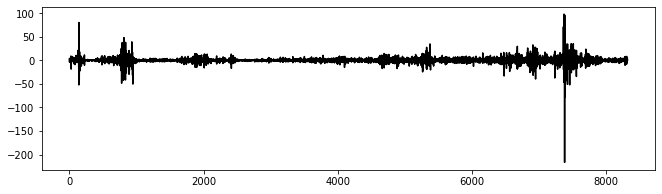

In [537]:
plt.figure(figsize=(11,3))
plt.plot(u, '-k');

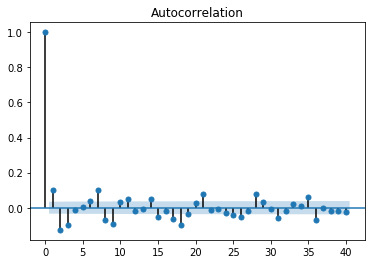

In [538]:
#Se grafica la ACF a la nueva serie
plot_acf(u[5000:],lags=40)
pyplot.show()

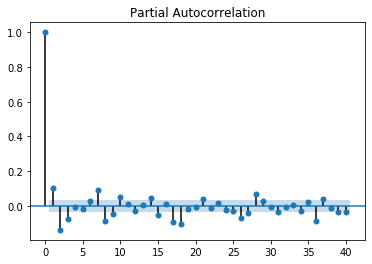

In [539]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(u[5000:], lags=40)
pyplot.show()

In [540]:
# Se realiza un tanteo de valores para la tasa de entrenamiento
# También como el retardo debe ser mayor a una semana debido al comportamiento
# de las series de precios se tantea también el rezago.
optimal_learning_rate = None
optimal_sse = None
optimal_P=None
for P in range(7,31):
   
    for learning_rate in np.linspace(start=0.00001, stop=0.01, num=100):

        adaline = AdalineTS(P=P,learning_rate=learning_rate)

        forecasts = []

        for z in u[:-7]:
            forecasts.append(adaline.predict())
            adaline.fit(z)

        sse = sum([(a-b)**2 for a,b in zip(u[P:-7], forecasts[P:])])

        if optimal_sse is None or sse < optimal_sse:
            optimal_sse = sse
            optimal_learning_rate = learning_rate
            optimal_P = P
        
print('La tasa de aprendizaje optima para la serie sin Transformación previa',
      ' es learningRate = {} con un error de SSE= {} y un retardo P = {}'.format(optimal_learning_rate, optimal_sse,optimal_P))
          

    

C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add
C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\BocanegraMartinez\Anaconda3\envs\Vision\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


La tasa de aprendizaje optima para la serie sin Transformación previa  es learningRate = 1e-05 con un error de SSE= 338446.4976974966 y un retardo P = 7


In [541]:
# Se hace nuevamente el modelo para todos los datos
# Con los valores óptimos de tasa de aprendizaje y Rezago
adaline = AdalineTS(
    P=optimal_P,
    learning_rate=optimal_learning_rate)

forecasts = []

for z in u:
    forecasts.append(adaline.predict())
    adaline.fit(z)

In [542]:
#Se realiza la integración de los datos para que los valores concuerden con los reales y posteriormente graficalos
d = dDef.tolist()
s = [m + n for m,n in zip(d[optimal_P:len(d)-1], forecasts[optimal_P:])]
s = d[0:optimal_P+1] + s
len(s)

8326

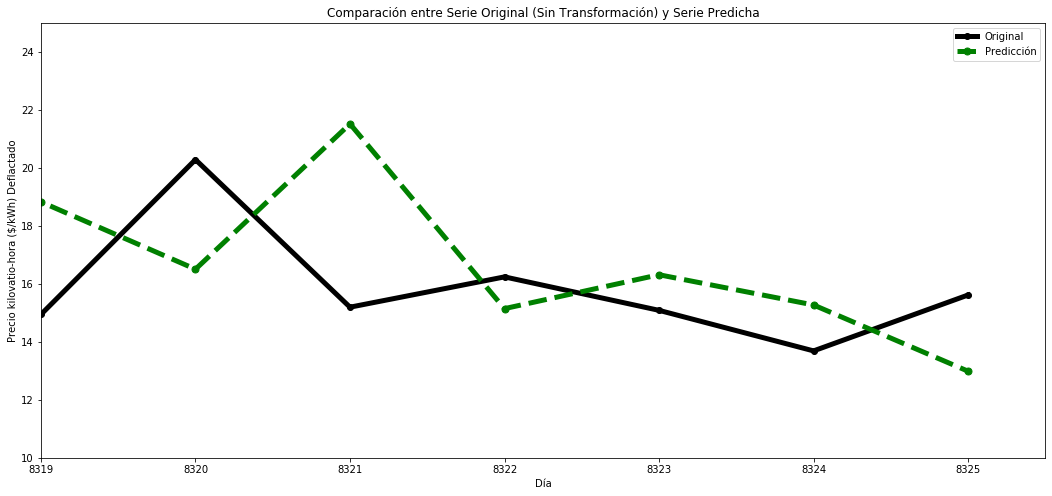

In [543]:
plt.figure(figsize=(18,8))
plt.xlim(8319,8325.5)
plt.ylim(10,25)
plt.title('Comparación entre Serie Original (Sin Transformación) y Serie Predicha')
plt.ylabel('Precio kilovatio-hora ($/kWh) Deflactado')
plt.plot(d, color='black',label='Original',marker='o',linewidth=5);
plt.plot(s, color = 'green',label='Predicción', marker='o',linestyle='dashed',linewidth=5, markersize=7);
plt.xlabel('Día')
plt.legend()

In [545]:
# cómputo del MSE
listaMse =[]
def_Mse_fit = sum([(a - b)**2 for a,b in zip(d[optimal_P+1:-7], s[optimal_P+1:-7])]) / len(s[optimal_P+1:-7])
def_Mse_fore = sum([(a - b)**2 for a,b in zip(d[-7:], s[-7:])]) / len(s[-7:])
listaMse.append(["Sin Transformar",def_Mse_fit,def_Mse_fore])
print("MSE Training: " + str(def_Mse_fit))
print("MSE Forecast: " + str( def_Mse_fore))

MSE Training: 40.722716604198844
MSE Forecast: 11.63661032618634


## Serie Estandarizada ([x - Media]/DesvEst)

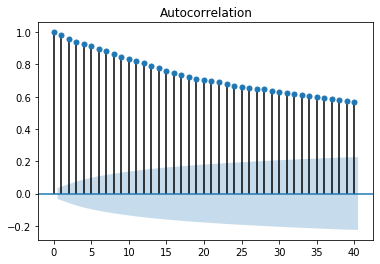

In [546]:
plot_acf(dNor[5000:],lags=40)
pyplot.show()

In [547]:
#Cambio lento de la serie
# diferenciación de la serie original: ut=zt−zt−1
uNor = np.array(dNor[1:len(dNor)]) - np.array(dNor[0:len(dNor) - 1])

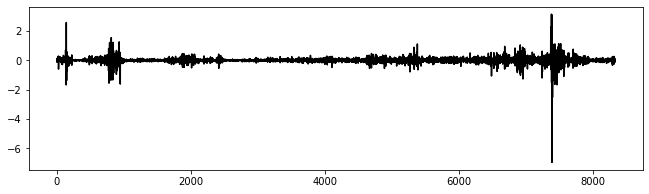

In [548]:
plt.figure(figsize=(11,3))
plt.plot(uNor, '-k');

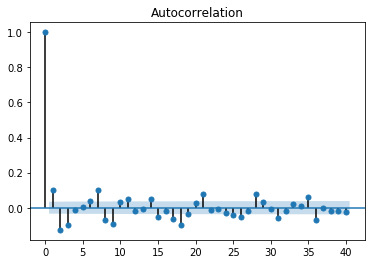

In [549]:
#Se grafica la ACF a la nueva serie
plot_acf(uNor[5000:],lags=40)
pyplot.show()

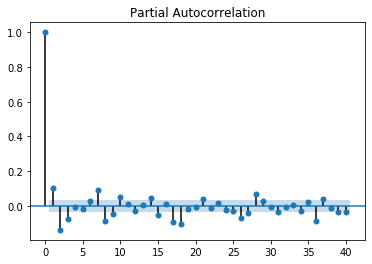

In [550]:
plot_pacf(uNor[5000:], lags=40)
pyplot.show()

In [551]:
optimal_learning_rate = None
optimal_sse = None
optimal_P=None
for P in range(7,21):
   
    for learning_rate in np.linspace(start=0.00001, stop=0.01, num=100):

        adaline = AdalineTS(P=P,learning_rate=learning_rate)

        forecasts = []

        for z in uNor[:-7]:
            forecasts.append(adaline.predict())
            adaline.fit(z)

        sse = sum([(a-b)**2 for a,b in zip(uNor[P:-7], forecasts[P:])])

        if optimal_sse is None or sse < optimal_sse:
            optimal_sse = sse
            optimal_learning_rate = learning_rate
            optimal_P = P
        
print('La tasa de aprendizaje optima para la Serie Normalizada',
      ' es learningRate = {} con un error de SSE= {} y un retardo P = {}'.format(optimal_learning_rate, optimal_sse,optimal_P))
          


La tasa de aprendizaje optima para la Serie Normalizada  es learningRate = 0.0004136363636363637 con un error de SSE= 312.6368200371691 y un retardo P = 7


In [552]:
# Se hace nuevamente el modelo para todos los datos
#
adaline = AdalineTS(
    P=optimal_P,
    learning_rate=optimal_learning_rate)

forecasts = []

for z in uNor:
    forecasts.append(adaline.predict())
    adaline.fit(z)

In [553]:
dn = dNor.tolist()
sn = [m + n for m,n in zip(dn[optimal_P:len(dn)-1], forecasts[optimal_P:])]
sn = dn[0:optimal_P+1] + sn
len(sn)

8326

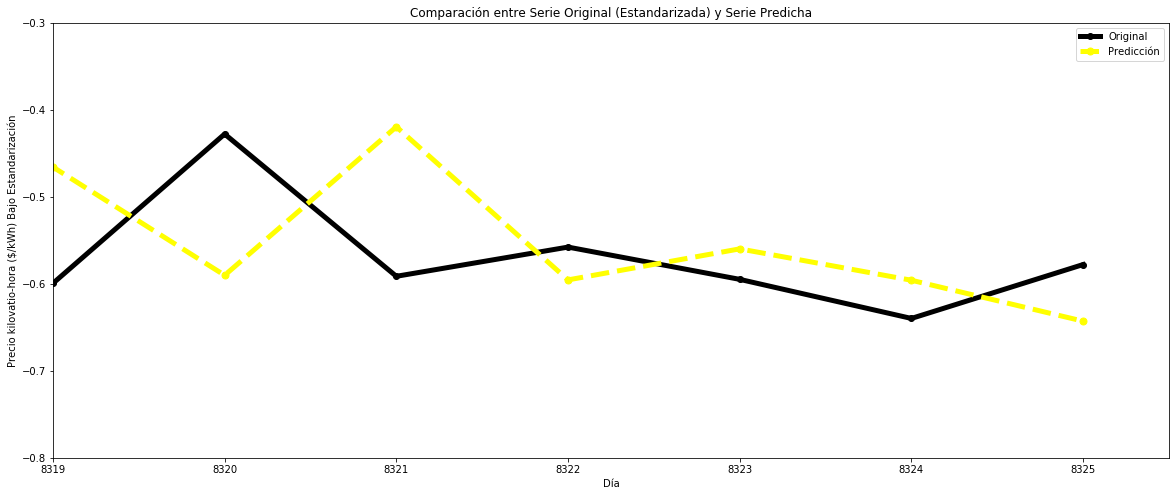

In [554]:
plt.figure(figsize=(20,8))
plt.xlim(8319,8325.5)
plt.ylim(-0.8,-0.3)
plt.title('Comparación entre Serie Original (Estandarizada) y Serie Predicha')
plt.ylabel('Precio kilovatio-hora ($/kWh) Bajo Estandarización')
plt.plot(dn, color='black',label='Original',marker='o',linewidth=5);
plt.plot(sn, color = 'yellow',label='Predicción', marker='o',linestyle='dashed',linewidth=5, markersize=7);
plt.xlabel('Día')
plt.legend()

In [555]:
# cómputo del MSE
norm_Mse_fit = sum([(a - b)**2 for a,b in zip(dn[optimal_P+1:-7], sn[optimal_P+1:-7])]) / len(sn[optimal_P+1:-7])
norm_Mse_fore = sum([(a - b)**2 for a,b in zip(dn[-7:], sn[-7:])]) / len(sn[-7:])
listaMse.append(["Estandarizada",norm_Mse_fit,norm_Mse_fore])
print("MSE Training: " + str(norm_Mse_fit))
print("MSE Forecast: " + str(norm_Mse_fore))

MSE Training: 0.037617232587795583
MSE Forecast: 0.011800981927478776


## Serie Transformada con Logaritmo Neperiano

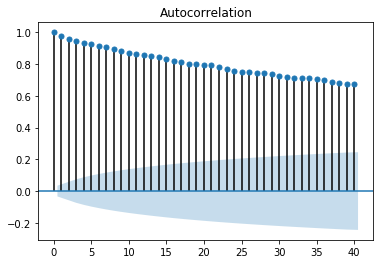

In [556]:
plot_acf(dLog[5000:],lags=40)
pyplot.show()

In [557]:
#Cambio lento de la serie
# diferenciación de la serie original: ut=zt−zt−1
uLog = np.array(dLog[1:len(dLog)]) - np.array(dLog[0:len(dLog) - 1])

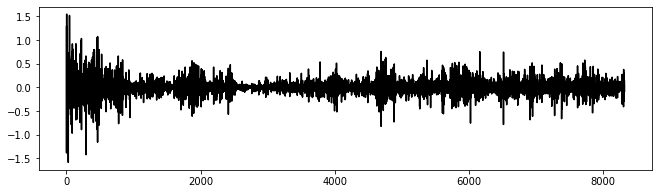

In [558]:
plt.figure(figsize=(11,3))
plt.plot(uLog, '-k');

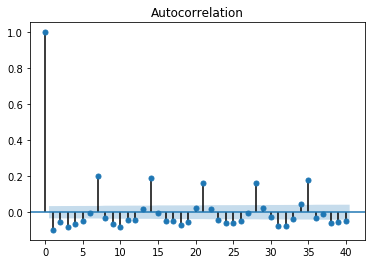

In [559]:
#Se grafica la ACF a la nueva serie
plot_acf(uLog[5000:],lags=40)
pyplot.show()

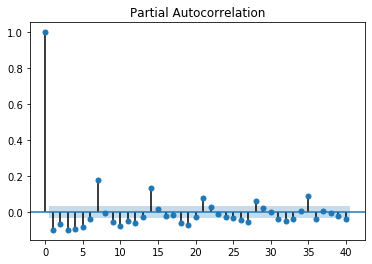

In [561]:
plot_pacf(uLog[5000:], lags=40)
pyplot.show()

In [563]:
optimal_learning_rate = None
optimal_sse = None
optimal_P=None
for P in range(7,31):
   
    for learning_rate in np.linspace(start=0.00001, stop=0.01, num=100):

        adaline = AdalineTS(P=P,learning_rate=learning_rate)

        forecasts = []

        for z in uLog[:-7]:
            forecasts.append(adaline.predict())
            adaline.fit(z)

        sse = sum([(a-b)**2 for a,b in zip(uLog[P:-7], forecasts[P:])])

        if optimal_sse is None or sse < optimal_sse:
            optimal_sse = sse
            optimal_learning_rate = learning_rate
            optimal_P = P
        
print('La tasa de aprendizaje optima para la Logaritmo Neperiano',
      ' es learningRate = {} con un error de SSE= {} y un retardo P = {}'.format(optimal_learning_rate, optimal_sse,optimal_P))
          

La tasa de aprendizaje optima para la Logaritmo Neperiano  es learningRate = 0.007376363636363637 con un error de SSE= 155.4813954126276 y un retardo P = 30


In [564]:
# Se hace nuevamente el modelo para todos los datos
#
adaline = AdalineTS(
    P=optimal_P,
    learning_rate=optimal_learning_rate)

forecasts = []

for z in uLog:
    forecasts.append(adaline.predict())
    adaline.fit(z)

In [565]:
dl = dLog.tolist()
sl = [m + n for m,n in zip(dl[optimal_P:len(dl)-1], forecasts[optimal_P:])]
sl = dl[0:optimal_P+1] + sl
len(sl)

8326

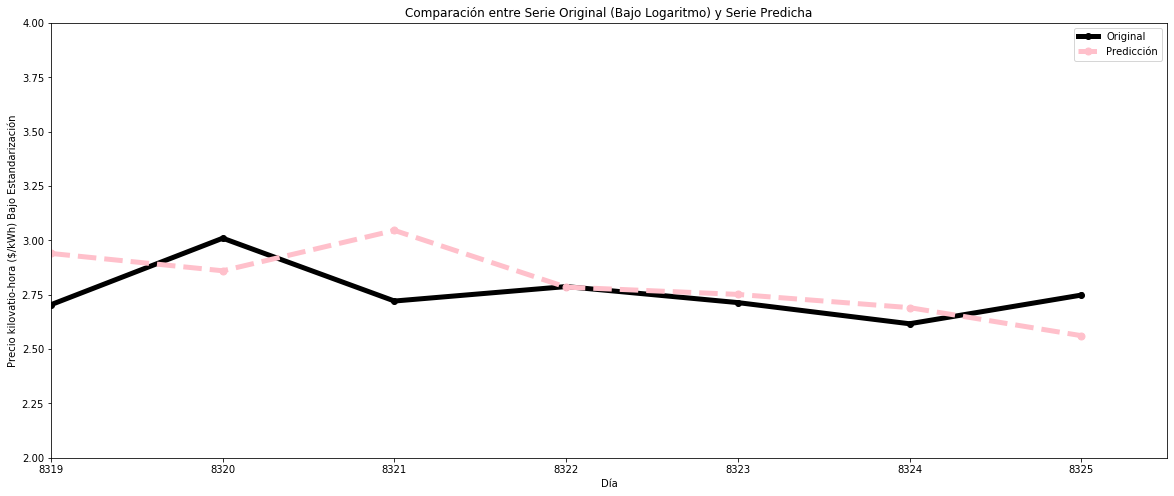

In [566]:
plt.figure(figsize=(20,8))
plt.xlim(8319,8325.5)
plt.ylim(2,4)
plt.title('Comparación entre Serie Original (Bajo Logaritmo) y Serie Predicha')
plt.ylabel('Precio kilovatio-hora ($/kWh) Bajo Estandarización')
plt.plot(dl, color='black',label='Original',marker='o',linewidth=5);
plt.plot(sl, color = 'pink',label='Predicción', marker='o',linestyle='dashed',linewidth=5, markersize=7);
plt.xlabel('Día')
plt.legend()

In [567]:
# cómputo del MSE
log_Mse_fit = sum([(a - b)**2 for a,b in zip(dl[optimal_P+1:-7], sl[optimal_P+1:-7])]) / len(sl[optimal_P+1:-7])
log_Mse_fore = sum([(a - b)**2 for a,b in zip(dl[-7:], sl[-7:])]) / len(sl[-7:])
listaMse.append(["Logaritmo",log_Mse_fit,log_Mse_fore])
print("MSE Training: " + str(log_Mse_fit))
print("MSE Forecast: " + str( log_Mse_fore))

MSE Training: 0.018759820875075724
MSE Forecast: 0.032165904299106755


## Serie Transformada con Raíz Cuadrada

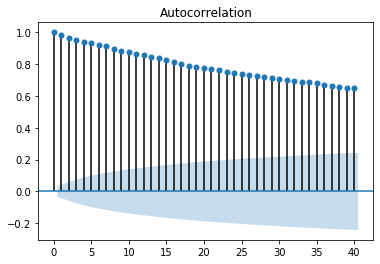

In [568]:
plot_acf(dR2[5000:],lags=40)
pyplot.show()

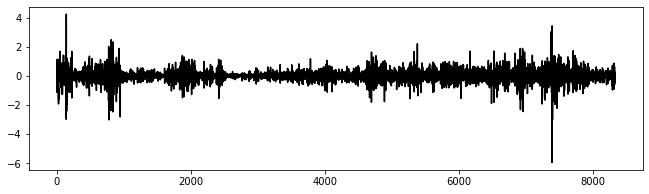

In [569]:
#Cambio lento de la serie
# diferenciación de la serie original: ut=zt−zt−1
uR2 = np.array(dR2[1:len(dR2)]) - np.array(dR2[0:len(dR2) - 1])
plt.figure(figsize=(11,3))
plt.plot(uR2, '-k');

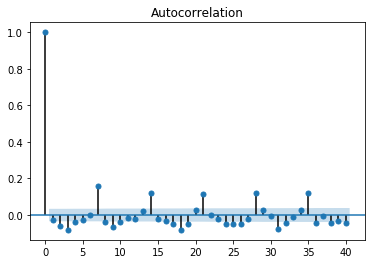

In [570]:
#Se grafica la ACF a la nueva serie
plot_acf(uR2[5000:],lags=40)
pyplot.show()

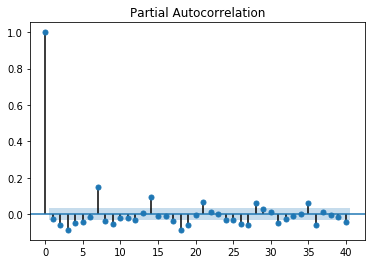

In [571]:
plot_pacf(uR2[5000:], lags=40)
pyplot.show()

In [572]:
optimal_learning_rate = None
optimal_sse = None
optimal_P=None
for P in range(7,31):
   
    for learning_rate in np.linspace(start=0.00001, stop=0.01, num=100):

        adaline = AdalineTS(P=P,learning_rate=learning_rate)

        forecasts = []

        for z in uR2[:-7]:
            forecasts.append(adaline.predict())
            adaline.fit(z)

        sse = sum([(a-b)**2 for a,b in zip(uR2[P:-7], forecasts[P:])])

        if optimal_sse is None or sse < optimal_sse:
            optimal_sse = sse
            optimal_learning_rate = learning_rate
            optimal_P = P
        
print('La tasa de aprendizaje optima para la Raíz Cuadrada',
      ' es learningRate = {} con un error de SSE= {} y un retardo P = {}'.format(optimal_learning_rate, optimal_sse,optimal_P))
       

La tasa de aprendizaje optima para la Raíz Cuadrada  es learningRate = 0.0011200000000000001 con un error de SSE= 1075.0293182419082 y un retardo P = 28


In [573]:
# Se hace nuevamente el modelo para todos los datos
#
adaline = AdalineTS(
    P=optimal_P,
    learning_rate=optimal_learning_rate)

forecasts = []

for z in uR2:
    forecasts.append(adaline.predict())
    adaline.fit(z)

In [574]:
dr2 = dR2.tolist()
sr2 = [m + n for m,n in zip(dr2[optimal_P:len(dr2)-1], forecasts[optimal_P:])]
sr2 = dr2[0:optimal_P+1] + sr2
len(sr2)

8326

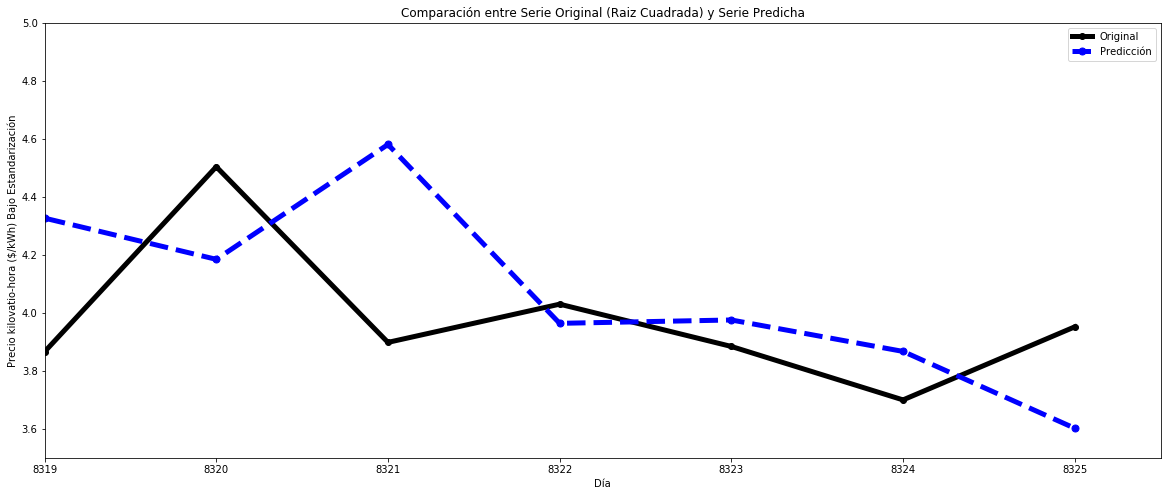

In [575]:
plt.figure(figsize=(20,8))
plt.xlim(8319,8325.5)
plt.ylim(3.5,5)
plt.title("Comparación entre Serie Original (Raiz Cuadrada) y Serie Predicha")
plt.ylabel('Precio kilovatio-hora ($/kWh) Bajo Estandarización')
plt.plot(dr2, color='black',label='Original',marker='o',linewidth=5);
plt.plot(sr2, color = 'blue',label='Predicción', marker='o',linestyle='dashed',linewidth=5, markersize=7);
plt.xlabel('Día')
plt.legend()

In [576]:
# cómputo del MSE
dR2_Mse_fit = sum([(a - b)**2 for a,b in zip(dr2[optimal_P+1:-7], sr2[optimal_P+1:-7])]) / len(sr2[optimal_P+1:-7])
dR2_Mse_fore = sum([(a - b)**2 for a,b in zip(dr2[-7:], sr2[-7:])]) / len(sr2[-7:])
listaMse.append(["Raíz Cuadrada",dR2_Mse_fit,dR2_Mse_fore])
print("MSE Training: " + str(dR2_Mse_fit))
print("MSE Forecast: " + str( dR2_Mse_fore))

MSE Training: 0.12967784297248594
MSE Forecast: 0.1347778305294109


## Serie Transformada bajo Raíz Cúbica

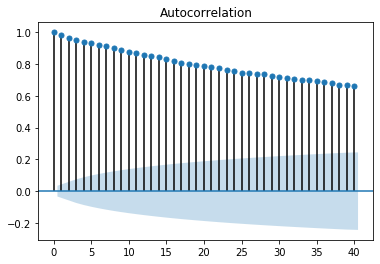

In [578]:
plot_acf(dR3[5000:],lags=40)
pyplot.show()

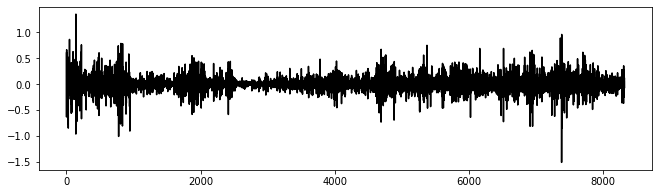

In [579]:
#Cambio lento de la serie
# diferenciación de la serie original: ut=zt−zt−1
uR3 = np.array(dR3[1:len(dR3)]) - np.array(dR3[0:len(dR3) - 1])
plt.figure(figsize=(11,3))
plt.plot(uR3, '-k');

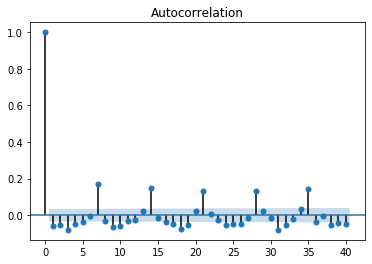

In [580]:
#Se grafica la ACF a la nueva serie
plot_acf(uR3[5000:],lags=40)
pyplot.show()

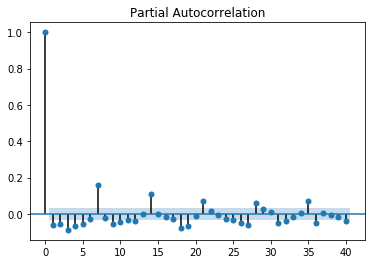

In [581]:
# Se grafica la PACF
plot_pacf(uR3[5000:], lags=40)
pyplot.show()

In [582]:
optimal_learning_rate = None
optimal_sse = None
optimal_P=None
for P in range(7,31):
   
    for learning_rate in np.linspace(start=0.00001, stop=0.01, num=100):

        adaline = AdalineTS(P=P,learning_rate=learning_rate)

        forecasts = []

        for z in uR3[:-7]:
            forecasts.append(adaline.predict())
            adaline.fit(z)

        sse = sum([(a-b)**2 for a,b in zip(uR3[P:-7], forecasts[P:])])

        if optimal_sse is None or sse < optimal_sse:
            optimal_sse = sse
            optimal_learning_rate = learning_rate
            optimal_P = P
        
print('La tasa de aprendizaje optima para laSerie bajo la Raíz Cúbica',
      ' es learningRate = {} con un error de SSE= {} y un retardo P = {}'.format(optimal_learning_rate, optimal_sse,optimal_P))


La tasa de aprendizaje optima para laSerie bajo la Raíz Cúbica  es learningRate = 0.00889 con un error de SSE= 141.82508806337154 y un retardo P = 28


In [583]:
# Se hace nuevamente el modelo para todos los datos
#
adaline = AdalineTS(
    P=optimal_P,
    learning_rate=optimal_learning_rate)

forecasts = []

for z in uR3:
    forecasts.append(adaline.predict())
    adaline.fit(z)

In [584]:
dr3 = dR3.tolist()
sr3 = [m + n for m,n in zip(dr3[optimal_P:len(dr3)-1], forecasts[optimal_P:])]
sr3 = dr3[0:optimal_P+1] + sr3
len(sr3)

8326

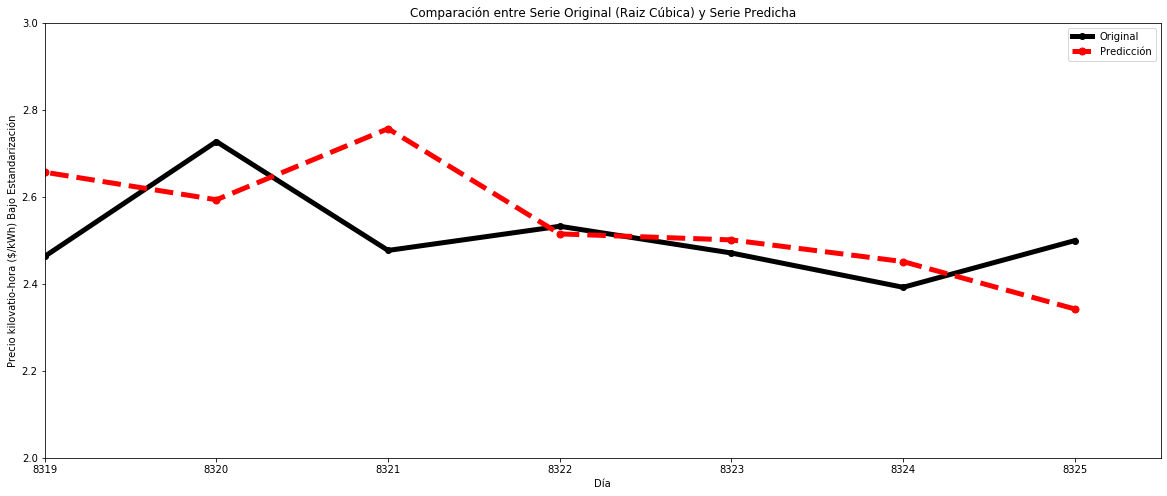

In [585]:
plt.figure(figsize=(20,8))
plt.xlim(8319,8325.5)
plt.ylim(2,3)
plt.title("Comparación entre Serie Original (Raiz Cúbica) y Serie Predicha")
plt.ylabel('Precio kilovatio-hora ($/kWh) Bajo Estandarización')
plt.plot(dr3, color='black',label='Original',marker='o',linewidth=5);
plt.plot(sr3, color = 'red',label='Predicción', marker='o',linestyle='dashed',linewidth=5, markersize=7);
plt.xlabel('Día')
plt.legend()

In [586]:
# cómputo del MSE
dR3_Mse_fit = sum([(a - b)**2 for a,b in zip(dr3[optimal_P+1:-7], sr3[optimal_P+1:-7])]) / len(sr3[optimal_P+1:-7])
dR3_Mse_fore = sum([(a - b)**2 for a,b in zip(dr3[-7:], sr3[-7:])]) / len(sr3[-7:])
listaMse.append(["Raíz Cúbica",dR3_Mse_fit,dR3_Mse_fore])
print("MSE Training: " + str(dR3_Mse_fit))
print("MSE Forecast: " + str(dR3_Mse_fore))

MSE Training: 0.01710797202211959
MSE Forecast: 0.02331977077584376


In [587]:
for MSE in listaMse:
    print(MSE)

['Sin Transformar', 40.722716604198844, 11.63661032618634]
['Estandarizada', 0.037617232587795583, 0.011800981927478776]
['Logaritmo', 0.018759820875075724, 0.032165904299106755]
['Raíz Cuadrada', 0.12967784297248594, 0.1347778305294109]
['Raíz Cúbica', 0.01710797202211959, 0.02331977077584376]


Ananlizando la lista de errores cuadráticos medios generadas por los modelos con cada transformación, vemos que los modelos con las series bajo las transformaciones de **Estandarización, Logaritmo Natural y Raiz Cúbica** tienen los mejores resultados pero analizando los resultados de la optimización de parámetros `la transformación adecuada es la Raíz Cúbica.`